In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import libraries

In [ ]:
!pip install eli5

In [ ]:
from datetime import datetime
import eli5
import geopy.distance
from IPython.display import SVG
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from xgboost import plot_importance
from xgboost.sklearn import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, scale, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVR
from statsmodels.tsa.seasonal import seasonal_decompose
import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import xgboost as xgb

In [ ]:
#load initial data

data_raw = pd.read_csv("/listings.csv", low_memory = False)

#load external data: points of interest in listings city
poi_data = pd.read_excel('/POIs.xlsx')

#display shape
print("{} Rows and {} Columns before preprocessing.".format(*data_raw.shape))

df = data_raw.copy()
df.head()

20244 Rows and 106 Columns before preprocessing.


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20190914033014,2019-09-14,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",From week 38 to week 47 maintenance work to th...,The neighbourhood is well served by 24 hours p...,NaN,NaN,Please: - Leave your shoes in the entrance - ...,NaN,NaN,https://a0.muscache.com/im/pictures/10272854/8...,NaN,3159,https://www.airbnb.com/users/show/3159,Daniel,2008-09-24,"Amsterdam, Noord-Holland, The Netherlands","Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,NaN,t,https://a0.muscache.com/im/users/3159/profile_...,https://a0.muscache.com/im/users/3159/profile_...,Indische Buurt,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Amsterdam, North Holland, Netherlands",Indische Buurt,Oostelijk Havengebied - Indische Buurt,...,$20.00,3,15,3,3,15,15,3.0,15.0,4 days ago,t,10,30,60,70,2019-09-14,269,28,2009-03-30,2019-09-03,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,"{Amsterdam,"" NL Zip Codes 2"","" Amsterdam"","" NL""}",t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.11
1,20168,https://www.airbnb.com/rooms/20168,20190914033014,2019-09-14,Studio with private bathroom in the centre 1,"Cozy studio on your own private floor, 100% in...",For those who like all facets of city life. In...,"Cozy studio on your own private floor, 100% in...",none,Located just in between famous central canals....,Check-in time from 2pm till 10pm (But it doesn...,No need to use any transport! All is within a ...,NaN,"No curfew, free entrance 27/7 with your own ke...",This studio/room takes entire floor and has it...,NaN,NaN,https://a0.muscache.com/im/pictures/69979664/3...,NaN,59484,https://www.airbnb.com/users/show/59484,Alexander,2009-12-02,"Amsterdam, Noord-Holland, The Netherlands",Secondary phone nr. + (Phone number hidden by ...,within a few hours,100%,NaN,f,https://a0.muscache.com/im/pictures/user/579c8...,https://a0.muscache.com/im/pictures/user/579c8...,Grachtengordel,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Amsterdam, North Holland, Netherlands",Grachtengordel,Centrum-Oost,...,$0.00,1,1000,1,4,1000,1000,3.4,1000.0,today,t,7,33,57,167,2019-09-14,288,68,2010-03-02,2019-08-28,88.0,10.0,10.0,10.0,10.0,10.0,9.0,f,NaN,"{Amsterdam,"" NL Zip Codes 2"","" Amsterdam"","" NL""}",f,f,strict_14_with_grace_period,f,f,2,0,2,0,2.48
2,25428,https://www.airbnb.com/rooms/25428,2019091

## 1. Preprocessing

###Deciding which columns to keep

Columns that are dropped are:
- redundant
- inconstistent
- too many missing values

,sum_na
host_acceptance_rate,20244
thumbnail_url,20244
neighbourhood_group_cleansed,20244
xl_picture_url,20244
medium_url,20244
license,20212
square_feet,19873
monthly_price,18907
weekly_price,17740
notes,11381


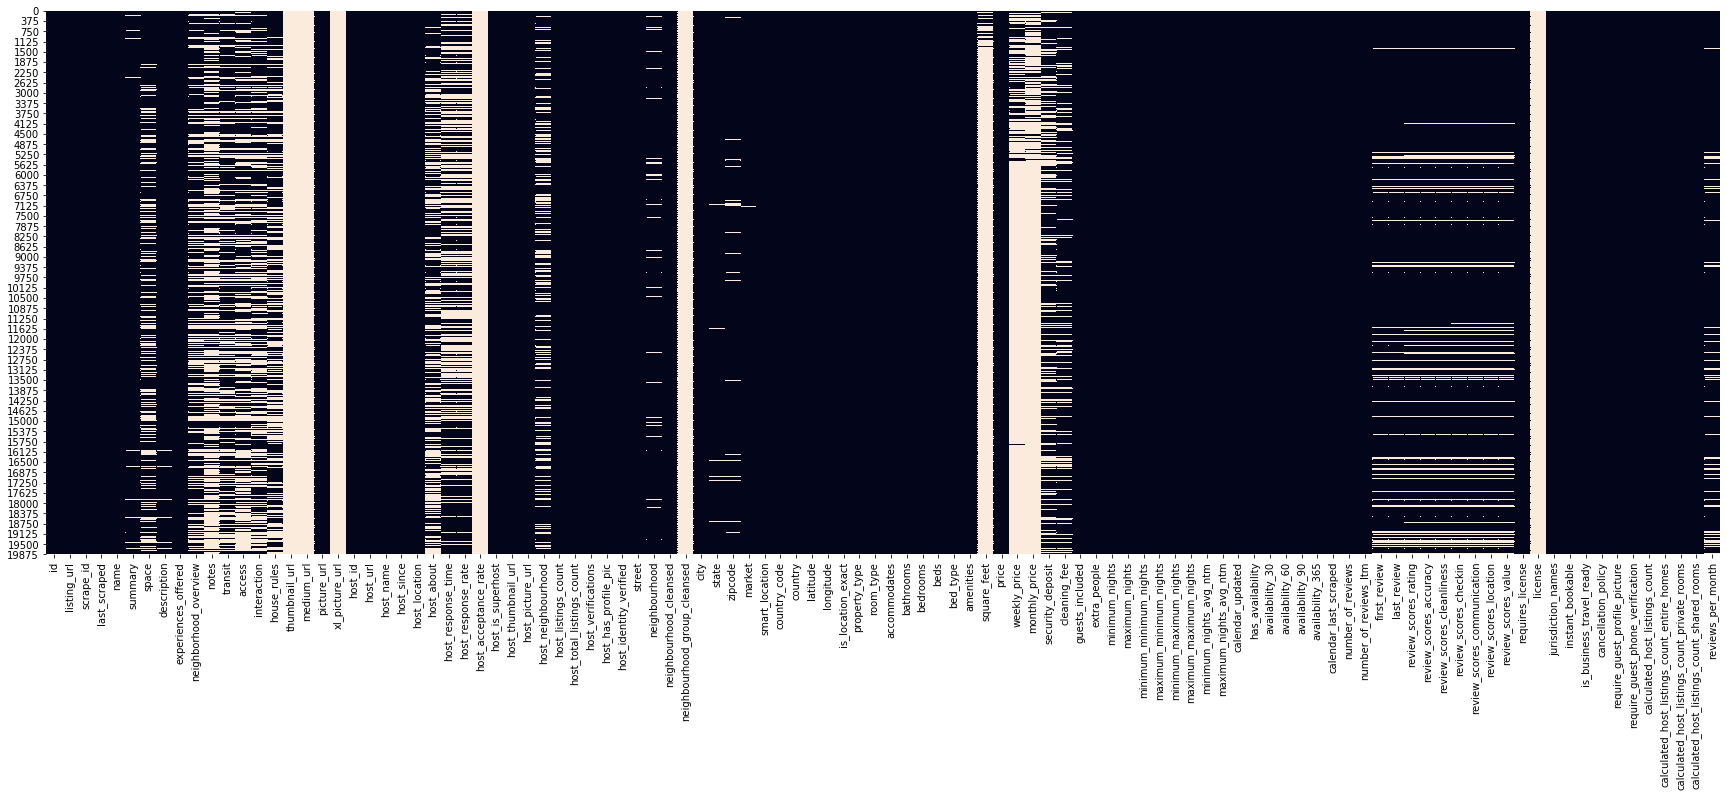

In [ ]:
#how many missing values do we have?

is_na = pd.DataFrame((df.isna().sum()), columns=["sum_na"])
display(is_na[is_na["sum_na"]!=0].sort_values(by=["sum_na"], ascending = False))
#visualize missing data
fig, ax = plt.subplots(figsize=(30,10))
sns.heatmap(data_raw.isnull(),ax=ax, cbar=False)

In [ ]:
columns_to_drop = [ 'square_feet','name','host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'street', 'neighbourhood', 'neighbourhood_group_cleansed', 'city', 'state',
                   'zipcode', 'market','country', 'smart_location','country_code','minimum_minimum_nights', 'maximum_maximum_nights','has_availability', 'calendar_last_scraped', 'jurisdiction_names',
                   'calculated_host_listings_count', 'listing_url', 'scrape_id','experiences_offered','thumbnail_url','medium_url','picture_url','xl_picture_url',
                   'host_id', 'host_url', 'host_name', 'host_response_rate', 'host_response_time','maximum_minimum_nights','minimum_maximum_nights', 'host_total_listings_count' ]

df.drop(columns=(columns_to_drop),inplace=True)

#drop columns
print("{} Rows and {} Columns removing inconsistent and redundant columns.".format(*df.shape))

20244 Rows and 68 Columns removing inconsistent and redundant columns.


###Feature engineering

- Deal with inconsistent/missing values
- Turn text data into numerical data (length of text)
- Deal with dates

Create distance features with external data and lat and long

In [ ]:
## calculate distances of each listing to airport, train station and the average of the top ten points of interest according to TripAdvisor

# create tuples with latitude and longitude data of listings, POIs, airport and train station for distance calculation

data_subset = df[['id', 'latitude', 'longitude']]
data_loc = [tuple(x) for x in data_subset.values]

poi_subset = poi_data[['Lat', 'Long']]
poi_loc = [tuple(x) for x in poi_subset.values]

poi_coords = [poi_loc[0], poi_loc[1], poi_loc[2], poi_loc[3], poi_loc[4], poi_loc[5], poi_loc[6], poi_loc[7], poi_loc[8], poi_loc[9]]
air_coords = poi_loc[10]
train_coords = poi_loc[11]

# calculate average distance of each listing to top ten POIs in respective city

def poi_dist(lat, long):
  list_coords = [lat, long]

  x = 0
  help = 0

  while x < 10:
    help = help + geopy.distance.vincenty(list_coords, poi_coords[x]).km
    x = x + 1
  poi_avg_dist = help / 10

  return poi_avg_dist

avg2poi = [None] * len(data_loc)
x = 0

while x < len(data_loc):
  avg2poi[x] = poi_dist(data_loc[x][1], data_loc[x][2])
  x = x + 1

df['avg2poi'] = avg2poi

# calculate distance of listing to airport

def air_dist(lat, long):
  list_coords = [lat, long]

  air_dist = geopy.distance.vincenty(list_coords, air_coords).km

  return air_dist

dist2air = [None] * len(data_loc)
x = 0

while x < len(data_loc):
  dist2air[x] = air_dist(data_loc[x][1], data_loc[x][2])
  x = x + 1

df['dist2air'] = dist2air

# calculate distance of listing to train station

def train_dist(lat, long):
  list_coords = [lat, long]

  train_dist = geopy.distance.vincenty(list_coords, train_coords).km

  return train_dist

dist2train = [None] * len(data_loc)
x = 0

while x < len(data_loc):
  dist2train[x] = train_dist(data_loc[x][1], data_loc[x][2])
  x = x + 1

df['dist2train'] = dist2train

#drop columns that are not needed anymore


Check if host is located in same city as listing and create new (boolean) feature for it


In [ ]:
## check if host is located in same city as listing and create new (boolean) feature for it

data_subset2 = df[['id', 'host_location']]
data_hl = [tuple(x) for x in data_subset2.values]
x = 0
array = [1] * len(data_hl)

while x < len(data_hl):
  if "Amsterdam" in str(data_hl[x]):
    array[x] = 1
    x = x + 1
  else:
    array[x] = 0
    x = x + 1

df['host_loc_same'] = array

df.drop(columns=([ 'id','latitude','longitude', 'host_location']),inplace=True)

Turning text data to numerical features

In [ ]:
text_columns = ['description','summary','space','neighborhood_overview','notes','transit','access','interaction', 'house_rules','host_about']

for t in text_columns:
  df['{}_length'.format(t)] = df[t].str.len()
  df['{}_length'.format(t)].fillna(0,inplace=True)


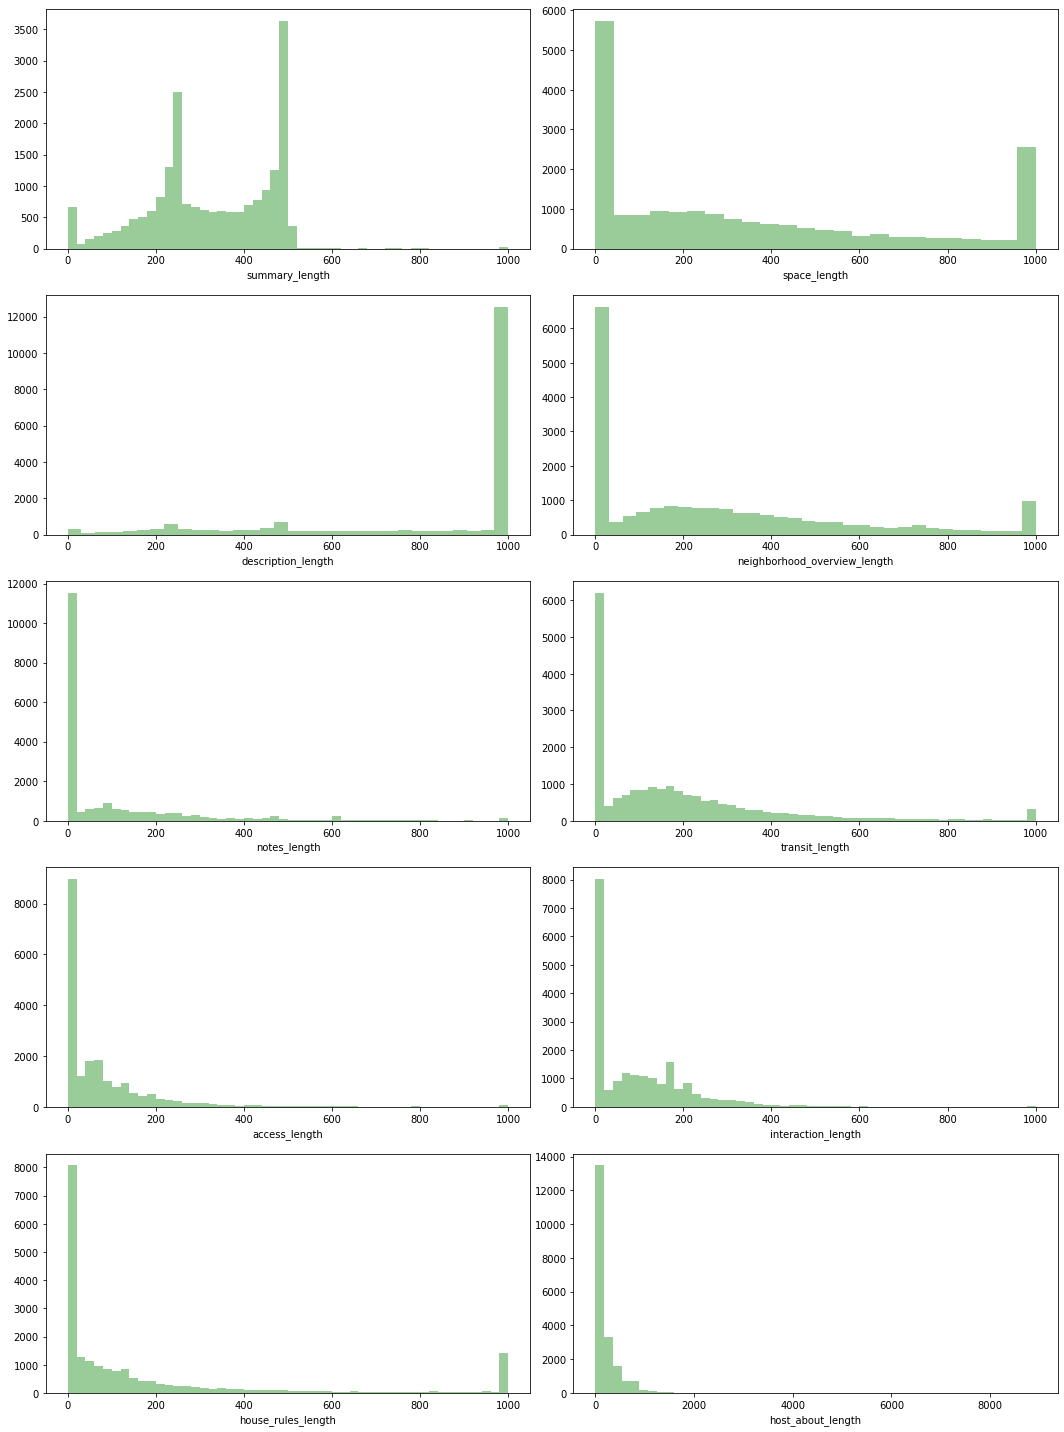

In [ ]:
# show length distribution for all text columns
# setup a figure
columns = ['summary_length','space_length','description_length',
           'neighborhood_overview_length','notes_length','transit_length',
           'access_length','interaction_length','house_rules_length', 'host_about_length']
plt.figure(figsize=(15,20))
# loop over all relevant columns
for x in columns:
    i = columns.index(x)+1
    plt.subplot(5,2,i)
    plt.tight_layout()
    sns.distplot(df[x], rug=False, kde=False, color="green")


In [ ]:
# description_length can't be used, because most times it is cut of after 1000 characters, drop the rest of the text data

df.drop(columns=(['description_length','description','summary','space','neighborhood_overview','notes','transit','access','interaction', 'house_rules', 'host_about']),inplace=True)


Calculate 'days_since_first_review' and 'days_since_last_review' using the 'last_scraped' column

In [ ]:
# use date when data was scraped
last_scraped_date = pd.to_datetime(df['last_scraped'].iloc[0], format='%Y-%m-%d')
df.drop(columns=('last_scraped'),inplace=True)

# convert columns into datetime
df['days_since_first_review'] = last_scraped_date - pd.to_datetime(df['first_review'], format='%Y-%m-%d')
df['days_since_last_review'] = last_scraped_date - pd.to_datetime(df['last_review'], format='%Y-%m-%d')

# convert days to numeric value
df['days_since_first_review'] = df['days_since_first_review'].dt.days
df['days_since_last_review'] = df['days_since_last_review'].dt.days

df.drop(columns=(['first_review','last_review']),inplace=True)

Create host since feature

In [ ]:
# convert column into datetime
df['host_since'] = last_scraped_date - pd.to_datetime(df['host_since'], format='%Y-%m-%d')

# convert days to numeric value
df['host_since'] = df['host_since'].dt.days

df.drop(columns=(['host_since']),inplace=True)

###Feature encoding

- Convert t/f into binary columns
- One-hot encode categorical features
- Label encode ordinal features



**Dealing with prices**
The following columns are prices:

*   price (target variable)
*   weekly_price
*   monthly_price
*   security_deposit
*   cleaning_fee
*   extra people

In [ ]:
#First of all, all prices come with a dollar sign making them into strings. We will remove them so that they'll be treated as floats

price_columns = ["price", "weekly_price", "monthly_price", "security_deposit", "cleaning_fee", "extra_people"]

#extra_people is not a float yet because it contains dollar signs -> remove them
for p in price_columns:
    df[p]= df[p].str.replace('$', '').str.replace(',', '').astype(float)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


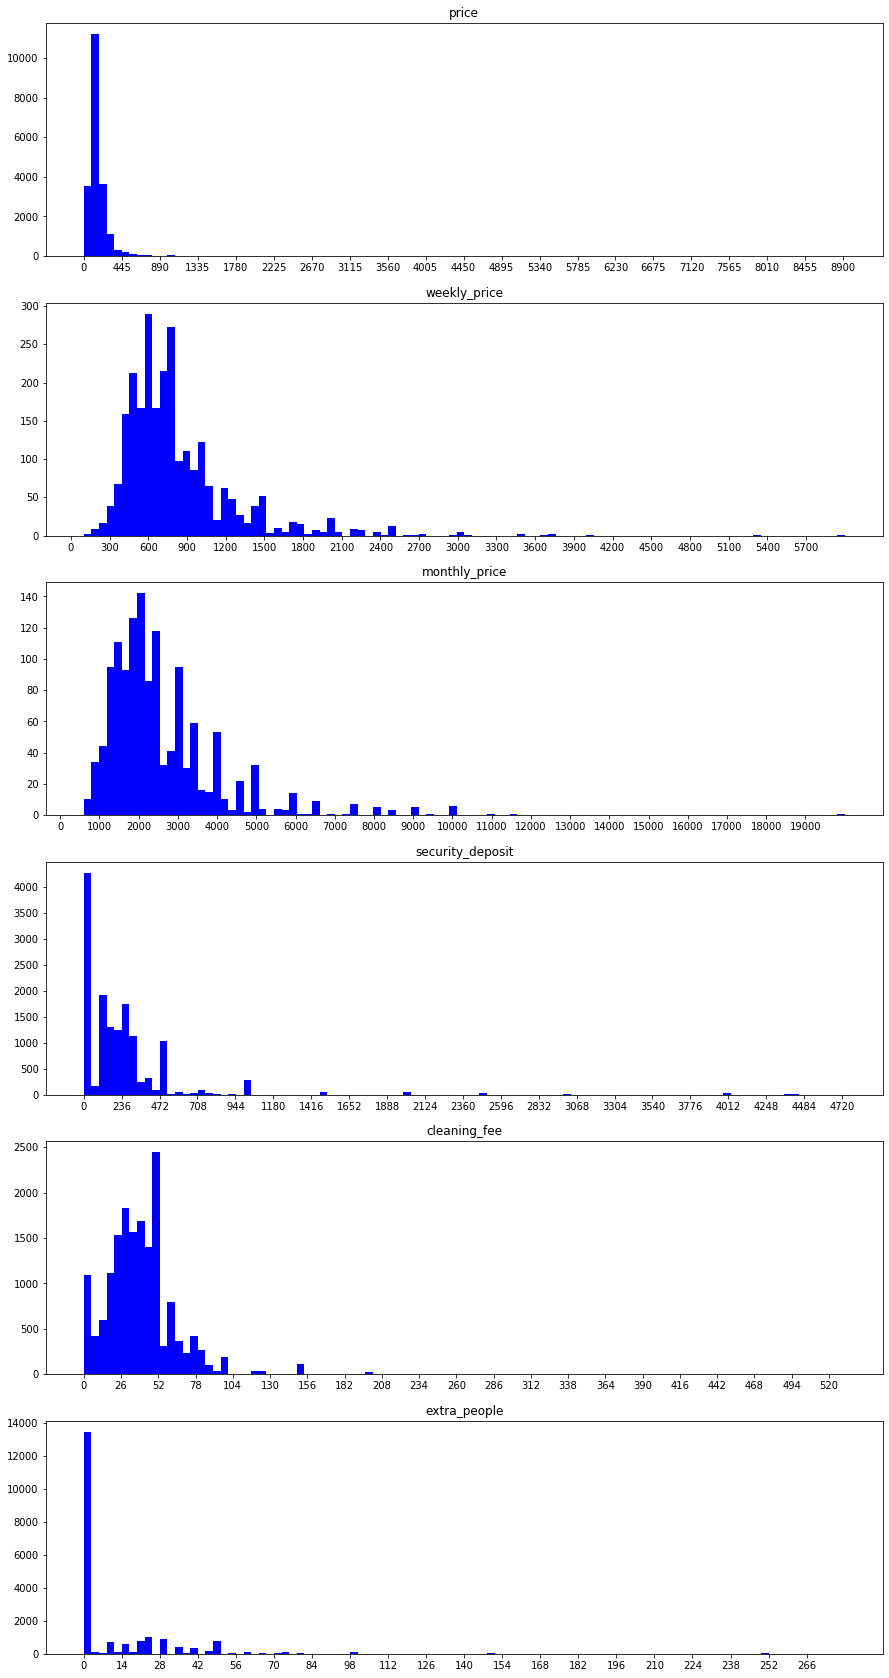

In [ ]:
#show the distribution of prices before wrangling
#loop over all relevant columns
fig, axes = plt.subplots(6,1,figsize=(15,30))
i=0
for p in price_columns:
    axes[i].set_title(p)
    axes[i].set_xticks(range(0,int(df[p].max()),int(df[p].max()/20)))
    axes[i].hist(df[p], color="blue",bins=100)
    i+=1

In [ ]:
#add feature for listings that have a "weekly_price", "monthly_price", "security_deposit", "cleaning_fee", "extra_people"

bool_prices= ["weekly_price", "monthly_price", "security_deposit", "cleaning_fee", "extra_people"]

for p in bool_prices:
    col_name = "has_{}".format(p)
    df[col_name]=df[p].isna().apply(lambda x: 1 if x == False else 0)
    df[col_name]=df[p].apply(lambda x: 0 if x == 0 else 1)


#while it is interesting if a host has made the effort to post (reduced) weekly and monthly prices they are somewhat redundant, we will only keep the binary columns
df.drop(columns=["weekly_price", "monthly_price"], inplace=True)


20243 Rows and 68 Columns after outlier removal prices = 0.


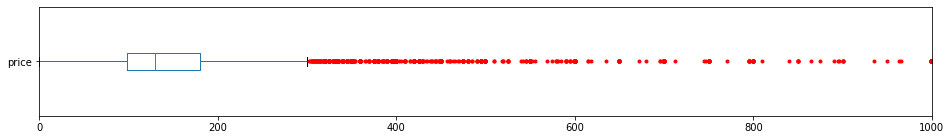

In [ ]:
#let's investigate the target variable further
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df["price"].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

#for consistency: let's remove the daily prices that are zero:
index = df[df["price"] == 0 ].index
df.drop(index, inplace=True)

print("{} Rows and {} Columns after outlier removal prices = 0.".format(*df.shape))

Transform the "calendar_updated" feature into numerical column

In [ ]:
#Check the feature "calendar_updated"

#first we want to look at the distribution of calendar updates

class_dist = df["calendar_updated"].value_counts()
display(class_dist)

display(df["calendar_updated"])
# we see that the number of unique values in this row is high (length = 75)
#also the mixup of days, months and other types is difficult to process

today            1745
2 months ago     1366
2 weeks ago      1219
4 days ago       1025
a week ago        942
                 ... 
60 months ago       3
54 months ago       2
64 months ago       1
56 months ago       1
59 months ago       1
Name: calendar_updated, Length: 75, dtype: int64

0         4 days ago
1              today
2          yesterday
3         4 days ago
4        6 weeks ago
            ...     
20239          today
20240          today
20241          today
20242          today
20243          today
Name: calendar_updated, Length: 20243, dtype: object

In [ ]:
# We will now transform the "calendar_updated" feature into numerical column the "day_since_calendar_updated" column
def calendar_updated_to_days (text):
    text_list = text.split()
    dig = [int(i) for i in text_list if i.isdigit()]
    if(text_list[0] == "never"):
        return 1920
    if (text_list[0]=="yesterday"):
        return 1
    if (text_list[0]=="today"):
        return 0
    if(text_list[0] == "a"):
        return 7
    if(text_list[1] == "week"):
        return 7
    if(text_list[1] == "days"):
        return dig[0]
    if(text_list[1] == "weeks"):
        return dig[0] * 7
    if(text_list[1] == "months"):
        return dig[0] * 30


In [ ]:
df["calendar_updated"] = df["calendar_updated"].map(calendar_updated_to_days)

Ordinal encode cancellation policy

In [ ]:
# encode columns ('cancellation_policy' and 'host_response_time') to ordinal categories

mapping = {'super_strict_60': 1,'super_strict_30': 2, 'strict_14_with_grace_period': 3, 'moderate': 4, 'flexible': 5}
df['cancellation_policy'] = df.cancellation_policy.map(mapping)

One hot encode neighborhoods, roomtypes, bed types, property types

In [ ]:
#get it ready for one-hot encoding, getting categories
df['neighbourhood_cleansed'] = pd.Categorical(df['neighbourhood_cleansed'])
#one hot encoding, each new line starts with neighbourhood_
dfDummies = pd.get_dummies(df['neighbourhood_cleansed'], prefix = 'neighbourhood_')
# use pd.concat to join the new columns with original dataframe
df = pd.concat([df,dfDummies],axis=1)

# now drop the original 'neighbourhood_cleansed' column
df.drop(['neighbourhood_cleansed'],axis=1, inplace=True)

#get it ready for one-hot encoding, getting categories
df['room_type'] = pd.Categorical(df['room_type'])
#one hot encoding, each new line starts with roomtype
dfDummies2 = pd.get_dummies(df['room_type'], prefix = 'roomtype_')
# use pd.concat to join the new columns with original dataframe
df = pd.concat([df,dfDummies2],axis=1)

# now drop the original'room_type' column
df.drop(['room_type'],axis=1, inplace=True)

#get it ready for one-hot encoding, getting categories
df['property_type'] = pd.Categorical(df['property_type'])
#one hot encoding, each new line starts with propertytype
dfDummies3 = pd.get_dummies(df['property_type'], prefix = 'propertytype_')
# use pd.concat to join the new columns with original dataframe
df = pd.concat([df,dfDummies3],axis=1)

# now drop the original 'property_type' column
df.drop(['property_type'],axis=1, inplace=True)


#get it ready for one-hot encoding, getting categories
df['bed_type'] = pd.Categorical(df['bed_type'])
#one hot encoding, each new line starts with bedtype
dfDummies5 = pd.get_dummies(df['bed_type'], prefix = 'bedtype_')
# use pd.concat to join the new columns with original dataframe
df = pd.concat([df,dfDummies5],axis=1)

# now drop the original 'bed_type' column
df.drop(['bed_type'],axis=1, inplace=True)

display(df)

,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,...,roomtype__Private room,roomtype__Shared room,propertytype__Aparthotel,propertytype__Apartment,propertytype__Barn,propertytype__Bed and breakfast,propertytype__Boat,propertytype__Boutique hotel,propertytype__Bungalow,propertytype__Bus,propertytype__Cabin,propertytype__Camper/RV,propertytype__Campsite,propertytype__Casa particular (Cuba),propertytype__Chalet,propertytype__Condominium,propertytype__Cottage,propertytype__Dome house,propertytype__Earth house,propertytype__Guest suite,propertytype__Guesthouse,propertytype__Hostel,propertytype__Hotel,propertytype__House,propertytype__Houseboat,propertytype__Island,propertytype__Lighthouse,propertytype__Loft,propertytype__Other,propertytype__Serviced apartment,propertytype__Tent,propertytype__Tiny house,propertytype__Townhouse,propertytype__Villa,propertytype__Yurt,bedtype__Airbed,bedtype__Couch,bedtype__Futon,bedtype__Pull-out Sofa,bedtype__Real Bed
0,t,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,f,2,1.5,1.0,2.0,"{Internet,Wifi,""Paid parking off premises"",""Bu...",59.0,200.0,60.0,1,20.0,3,15,3.0,15.0,4,10,30,60,70,269,28,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,t,f,3,f,f,...,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,f,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,t,2,1.0,1.0,1.0,"{TV,Internet,Wifi,""Paid parking off premises"",...",80.0,NaN,NaN,2,0.0,1,1000,3.4,1000.0,0,7,33,57,167,288,68,88.0,10.0,10.0,10.0,10.0,10.0,9.0,f,NaN,f,f,3,f,f,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,f,"['email', 'phone', 'reviews']",t,f,f,3,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Elevator,...",125.0,300.0,40.0,2,10.0,14,60,14.0,60.0,1,2,11,24,58,3,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,f,f,3,f,f,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,t,"['email', 'phone', 'reviews', 'jumio']",t,t,t,2,1.0,1.0,1.0,"{TV,Internet,Wifi,Breakfast,Heating,""Smoke det...",155.0,0.0,0.0,1,0.0,2,730,2.0,730.0,4,4,15,37,264,200,41,99.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,t,f,3,f,f,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,t,"['email', 'phone', 'reviews', 'jumio']",t,t,t,2,1.0,1.0,1.0,"{Internet,Wifi,""Pets live on this property"",Ca...",75.0,NaN,NaN,1,0.0,2,1825,2.0,1825.0,42,4,10,12,123,295,103,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,f,f,4,f,f,...,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20239,f,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,t,12,4.5,4.0,7.0,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",350.0,400.0,NaN,1,0.0,5,90,5.0,90.0,0,30,54,78,353,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,f,f,5,f,f,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
20240,f,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,t,6,2.5,3.0,3.0,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",200.0,400.0,

Splitting amenities into features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

df.amenities = df.amenities.str.replace("[{}]", "").str.replace('"', "")
count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count_vectorizer.fit_transform(df['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities = df_amenities.drop('',1)


Splitting host_verifications into features

In [ ]:
df.host_verifications = df.host_verifications.str.replace("\[", "").str.replace("'", "").str.replace("\]", "")
count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
verifications = count_vectorizer.fit_transform(df['host_verifications'])
df_verifications = pd.DataFrame( verifications.toarray(),columns=count_vectorizer.get_feature_names())
df_verifications = df_verifications.drop('',1)

Concatenating the new features and dropping the old ones

In [ ]:
df = pd.concat([df, df_amenities, df_verifications], axis=1, join='inner')
df.drop(['amenities','translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50', 'host_verifications'], axis=1, inplace=True)

Create binary features

In [ ]:
#turn features with f/t values into numerical binary features (0/1)
data_convert_columns = ['host_is_superhost','host_has_profile_pic','is_location_exact','instant_bookable',
                        'is_business_travel_ready','requires_license','require_guest_profile_picture',
                        'require_guest_phone_verification','host_identity_verified']

for c in data_convert_columns:
    df[c] = df[c].apply(lambda x: 1 if x == 't' else 0)

In [ ]:
# True if value = Nan, else False
# Replace True by 0 and False by 1
df['license'] = df['license'].isna().apply(lambda x: 0 if x == True else 1)

### Correlation analysis

In [ ]:
#show correlations
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(df[df.columns[1:]].corr()['price'][:].sort_values())

roomtype__Private room                                  -0.162063
avg2poi                                                 -0.115337
dist2air                                                -0.112233
cancellation_policy                                     -0.109766
calculated_host_listings_count_private_rooms            -0.088679
propertytype__Apartment                                 -0.082040
calendar_updated                                        -0.079604
number_of_reviews                                       -0.071417
number_of_reviews_ltm                                   -0.069149
has_cleaning_fee                                        -0.068358
 reviews                                                -0.061194
neighbourhood__Bos en Lommer                            -0.055899
host_loc_same                                           -0.052349
days_since_last_review                                  -0.051825
reviews_per_month                                       -0.040573
neighbourh

###Data Normalization

In [ ]:
## normalizes all (numerical) values between 0 an 1 (MinMax encoding)

target = df.price
df.drop(columns="price", inplace = True)

In [ ]:
numeric_features = df.columns.tolist()
numeric_transformer = Pipeline([('scaler', MinMaxScaler())])
preprocessor = ColumnTransformer(transformers = [('num', numeric_transformer, numeric_features)])
df[df.columns.tolist()] = preprocessor.fit_transform(df)

###Dealing with last missing values

In [ ]:
is_na = pd.DataFrame((df.isna().sum()), columns=["sum_na"])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(is_na[is_na["sum_na"]!=0].sort_values(by=["sum_na"], ascending = False))

                             sum_na
security_deposit               6053
cleaning_fee                   3611
review_scores_checkin          2584
review_scores_location         2582
review_scores_value            2582
review_scores_communication    2577
review_scores_accuracy         2575
review_scores_cleanliness      2573
review_scores_rating           2564
reviews_per_month              2341
days_since_first_review        2341
days_since_last_review         2341
bedrooms                         14
beds                              8
bathrooms                         7


In [ ]:
#create new feature for every column with nans
nan_columns = is_na[is_na["sum_na"]!=0].index.tolist()

for col in nan_columns:
  col_name = "is_na_{}".format(col)
  df[col_name]=df[col].isna().apply(lambda x: 1 if x == True else 0)

#turn nan values into -1
df[np.isnan(df)]=-1

## 2. Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

n_Folds = 5

bins = np.linspace(0, len(target), 5)

target_binned = np.digitize(target, bins)

df_train, df_test, target_train, target_test = train_test_split(df, target, test_size=0.3, random_state=42, stratify=target_binned)

##3. Building Models

Define show results function to ensure same output of results

In [ ]:
def show_results(estimator, name, params):
  train_pred = estimator.predict(df_train)
  mae_train = mean_absolute_error(target_train, train_pred)

  test_pred  = estimator.predict(df_test)
  mae_test = mean_absolute_error(target_test, test_pred)

  total_pred = estimator.predict(df)
  mae_total = mean_absolute_error(target, total_pred)
  rmse_total = sqrt(mean_squared_error(target, total_pred))
  r2_total = r2_score(target, total_pred)

  df_scores = pd.DataFrame({'algorithm':['{}:'.format(name)],
            'Train MAE': mae_train,
            'Test MAE': mae_test,
            'Total MAE': mae_total,
            'Train RMSE': sqrt(mean_squared_error(target_train, train_pred)),
            'Test RMSE':sqrt(mean_squared_error(target_test, test_pred)),
            'Total RMSE': rmse_total,
            'Train R2': r2_score(target_train, train_pred),
            'Test R2': r2_score(target_test, test_pred),
            'Total R2': r2_total,
            'Baseline': dummy_mae,
            'Delta': [dummy_mae - mae_total],
            'Improvement in %': [((dummy_mae - mae_total)/dummy_mae)*100]
            })

  display(df_scores)
  display(params)
  residuals_train = target_train- train_pred
  residuals_test = target_test- test_pred

  fig, ax = plt.subplots(1, 3, figsize=(15,5))

  ax[0].scatter(target, total_pred,  c='green', alpha=0.5)
  ax[0].plot([target.min(), target.max()],[target.min(), target.max()], 'k--')
  ax[0].set_xlabel('Target')
  ax[0].set_ylabel('Predicted')

  ax[1].scatter(target_test, test_pred, c='red', alpha=0.5 )
  ax[1].scatter(target_train, train_pred, c='blue', alpha=0.5 )
  ax[1].plot([target.min(), target.max()],[target.min(), target.max()], 'k--')
  ax[1].set_xlabel('Target')
  ax[1].set_ylabel('Predicted')

  ax[2].scatter(test_pred, residuals_test, c='red', alpha=0.5 )
  ax[2].scatter(train_pred, residuals_train, c='blue', alpha=0.5 )
  ax[2].plot([target_test.min(), target_test.max()],[0,0], 'k--')
  ax[2].set_xlabel('Predicted')
  ax[2].set_ylabel('Residuals')
  plt.show()

  return df_scores

###Baseline regressor

,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,Baseline: Mean dummy regressor:,68.953436,70.310385,69.360547,152.370942,185.371366,162.974894,-0.000036,-0.000131,0.0,69.360547,0.0,0.0


' '

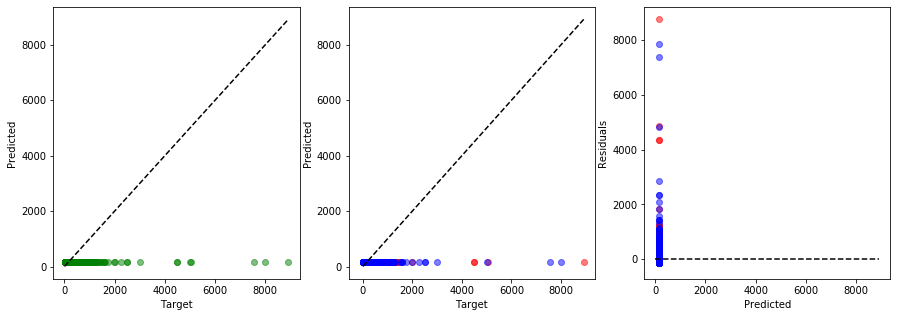

,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,Baseline: Mean dummy regressor:,68.953436,70.310385,69.360547,152.370942,185.371366,162.974894,-0.000036,-0.000131,0.0,69.360547,0.0,0.0


In [ ]:
baseline_est = DummyRegressor(strategy = 'mean')

baseline_est.fit(df, target)
predictions = baseline_est.predict(df)
dummy_mae = (mean_absolute_error(target, predictions))

show_results(baseline_est, 'Baseline: Mean dummy regressor', ' ')

###Ordinary linear regression

,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,OL regressor:,47.793327,5.750640e+08,1.725306e+08,128.972607,2.501565e+10,1.370209e+10,0.283517,-1.821357e+16,-7.068576e+15,69.360547,-1.725305e+08,-2.487445e+08


' '

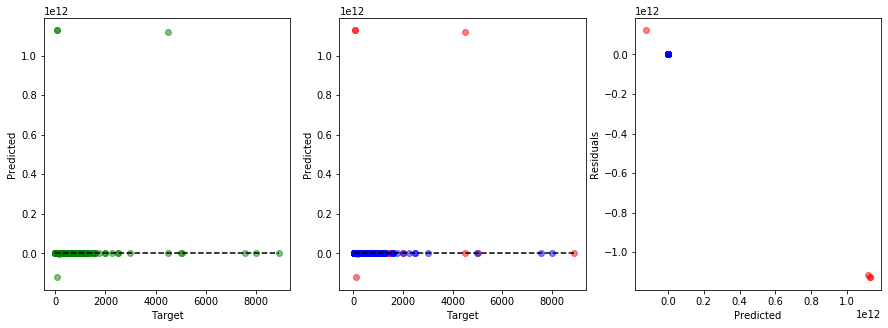

In [ ]:
from sklearn.linear_model import LinearRegression

olr_est = LinearRegression()
olr_est.fit(df_train, target_train)

OLS_score = show_results(olr_est, 'OL regressor', ' ')


### K-Nearest Neighbours Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

param_grid_knn = {
    'n_neighbors': [ 2,4,6,8,10, 12, 14, 16, 18, 20,22]
}

grid_search_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid = param_grid_knn, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'), refit="neg_mean_absolute_error", cv=5, n_jobs=-1, verbose=3)

# run the grid search
grid_search_knn.fit(df_train, target_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_knn.cv_results_)
display(results)

# print the best parameter setting
print("best score is {} with params {}".format(grid_search_knn.best_score_, grid_search_knn.best_params_))


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed: 12.2min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.422196,0.021878,49.896920,0.414850,2,{'n_neighbors': 2},-23536.580540,-32243.778140,-45038.957216,-12029.674929,-13131.260325,-25196.901722,12369.967564,11,-69.488532,-66.542872,-69.584157,-66.561927,-64.529121,-67.341520,1.938701,11
1,0.415620,0.046724,53.116152,3.011050,4,{'n_neighbors': 4},-15017.961053,-30451.556612,-44135.244465,-10698.743604,-11865.940765,-22434.635150,12958.725416,10,-63.989944,-62.211980,-64.732092,-61.496119,-60.237293,-62.533647,1.637451,10
2,0.459521,0.024467,56.641251,0.385269,6,{'n_neighbors': 6},-13433.709715,-29288.244795,-44241.987875,-10767.504783,-11518.087540,-21850.636127,13093.169868,9,-62.310515,-61.131087,-63.075923,-60.276523,-59.688081,-61.296539,1.252912,9
3,0.446626,0.030702,55.726154,0.482160,8,{'n_neighbors': 8},-13074.990048,-29707.959465,-43269.628457,-10173.257002,-11052.238694,-21456.348968,13036.340450,8,-61.594522,-60.826394,-62.141628,-59.188867,-58.723791,-60.495166,1.332129,8
4,0.406399,0.021952,49.024212,0.547808,10,{'n_neighbors': 10},-12570.183063,-29701.682604,-42925.812304,-10318.460826,-10934.418588,-21290.842347,12981.019525,7,-61.234721,-60.879534,-61.745131,-58.910445,-58.587787,-60.271642,1.277186,7
5,0.385803,0.011406,48.745131,0.298698,12,{'n_neighbors': 12},-12647.375284,-29664.407632,-42724.003100,-10435.023820,-10789.257628,-21252.751919,12902.334269,6,-60.848389,-60.591714,-61.347065,-59.001970,-58.308213,-60.019591,1.161054,6
6,0.400597,0.010802,49.786157,0.574888,14,{'n_neighbors': 14},-12498.087203,-29423.969159,-42674.196276,-10340.021249,-10725.105320,-21133.010344,12900.838664,5,-60.385724,-60.357269,-61.141093,-58.976132,-58.063310,-59.784827,1.108623,5
7,0.398804,0.014798,50.592375,0.284738,16,{'n_neighbors': 16},-12483.454731,-29444.788258,-42719.175900,-10227.759569,-10735.807789,-21122.930285,12937.617499,4,-60.407529,-60.026376,-60.780081,-58.636027,-58.168351,-59.603774,1.020287,4
8,0.395287,0.018916,50.871972,1.170165,18,{'n_neighbors': 18},-12314.642890,-29499.356803,-42884.676656,-10019.566539,-10718.820309,-21088.144419,13060.399590,3,-60.228456,-59.858112,-61.097820,-58.275759,-57.991391,-59.490413,1.182017,3
9,0.412539,0.017966,55.031504,1.487424,20,{'n_neighbors': 20},-12319.796201,-29474.711230,-42866.605703,-9958.515352,-10627.287610,-21050.118775,13075.415574,2,-60.138356,-59.831228,-61.216320,-58.333892,-57.657007,-59.435486,1.280466,1


best score is -59.43548591996613 with params {'n_neighbors': 20}


,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,KNN Regressor:,56.29386,60.741289,57.628177,137.528813,178.58307,151.022357,0.185298,0.071778,0.141301,69.360547,11.732371,16.915049


{'n_neighbors': 20}

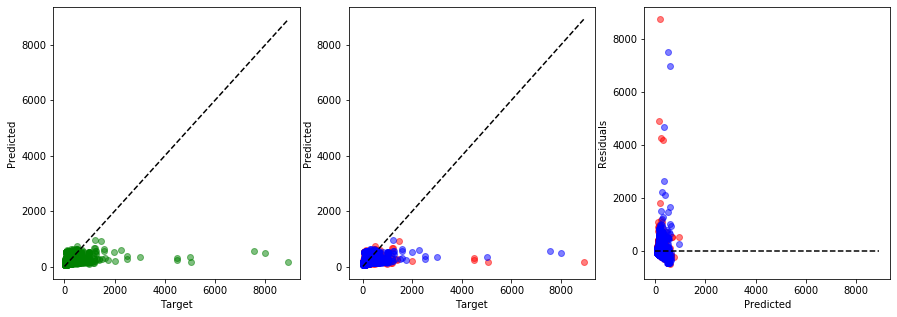

In [ ]:
knn_score = show_results(grid_search_knn.best_estimator_, 'KNN Regressor', grid_search_knn.best_params_)


###Ridge Regressor

In [ ]:
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

ridgecv = GridSearchCV(estimator = Ridge(), param_grid=dict(alpha=alphas), scoring ='neg_mean_absolute_error', cv=10)
ridgecv.fit(df_train, target_train)

results = pd.DataFrame(ridgecv.cv_results_)
display(results)

# print the best parameter setting
print("best score is {} with params {}".format((ridgecv.best_score_), ridgecv.best_params_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.118690,0.018644,0.007142,0.001421,100,{'alpha': 100},-54.756122,-49.192548,-55.706342,-48.076730,-56.770083,-51.352991,-53.811512,-47.986978,-47.996214,-49.727996,-51.537879,3.259233,9
1,0.133428,0.017070,0.009883,0.004420,10,{'alpha': 10},-51.618734,-46.228868,-53.101166,-45.455791,-54.535326,-49.747985,-51.163765,-46.070839,-45.281345,-47.910088,-49.111476,3.213683,2
2,0.122149,0.017362,0.008223,0.003163,1,{'alpha': 1},-51.626736,-45.615775,-53.187411,-45.335427,-53.569776,-49.795672,-50.629836,-45.998030,-45.286598,-48.519558,-48.956513,3.106578,1
3,0.121759,0.015521,0.006950,0.001640,0.1,{'alpha': 0.1},-52.081669,-45.749655,-53.582601,-45.591448,-53.454488,-50.096827,-50.632306,-46.295921,-45.642765,-48.962235,-49.209009,3.074803,3
4,0.121889,0.016010,0.007017,0.001679,0.01,{'alpha': 0.01},-52.183228,-45.785407,-53.652103,-45.621701,-53.443245,-50.149367,-50.662832,-46.365621,-45.718916,-49.035816,-49.261840,3.072098,4
5,0.120359,0.016392,0.006513,0.001628,0.001,{'alpha': 0.001},-52.196468,-45.789030,-53.661915,-45.623540,-53.445927,-50.154811,-50.695395,-46.372857,-45.727690,-49.042581,-49.271038,3.074406,5
6,0.119917,0.013813,0.007033,0.001619,0.0001,{'alpha': 0.0001},-52.198200,-45.789380,-53.663047,-45.623691,-53.446258,-50.155199,-50.702707,-46.373545,-45.728605,-49.043196,-49.272399,3.074895,6
7,0.110371,0.016143,0.006019,0.001858,1e-05,{'alpha': 1e-05},-52.198375,-45.789415,-53.663163,-45.623705,-53.446291,-50.155235,-50.703531,-46.373613,-45.728697,-49.043257,-49.272544,3.074949,7
8,0.117735,0.015702,0.006136,0.001733,1e-06,{'alpha': 1e-06},-52.198393,-45.789418,-53.663174,-45.623707,-53.446294,-50.155239,-50.703615,-46.373620,-45.728706,-49.043263,-49.272559,3.074955,8


best score is -48.95651265347676 with params {'alpha': 1}


,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,Ridge Regressor:,47.636932,50.559385,48.513726,129.050568,163.385773,140.237321,0.28265,0.223038,0.259567,69.360547,20.846821,30.055734


{'alpha': 1}

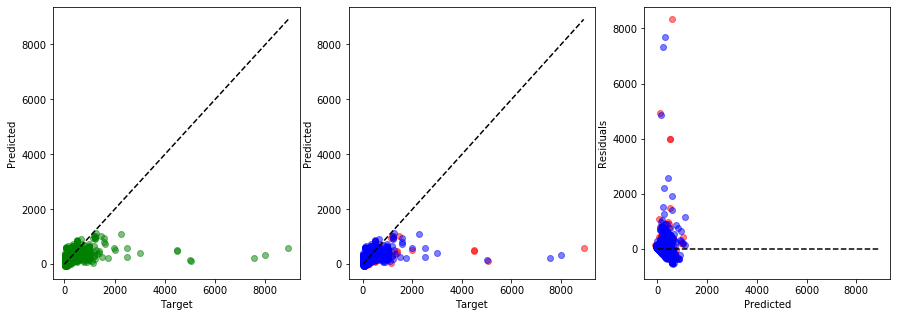

In [ ]:
rr_score=show_results(ridgecv, 'Ridge Regressor', ridgecv.best_params_)

### Lasso Regressor

In [ ]:
alphas = np.array([100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001])

lassocv = GridSearchCV(estimator = Lasso(), param_grid=dict(alpha=alphas), scoring ='neg_mean_absolute_error', cv=10)
lassocv.fit(df_train, target_train)

results = pd.DataFrame(lassocv.cv_results_)
display(results)

# print the best parameter setting
print("best score is {} with params {}".format((lassocv.best_score_), lassocv.best_params_))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65297.38891419768, tolerance: 31419.73285743413
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34215830.97515193, tolerance: 30367.335896863235
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47548086.48291354, tolerance: 31334.39812644291
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30177314.781364

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.083197,0.023471,0.007447,0.004503,100,{'alpha': 100.0},-71.355662,-67.039050,-72.915612,-66.606003,-72.546761,-68.386111,-70.466845,-64.672344,-64.723808,-67.751070,-68.646390,2.879139,9
1,0.145363,0.117672,0.007566,0.000913,10,{'alpha': 10.0},-71.232103,-66.899810,-72.484400,-66.389991,-72.427544,-68.034312,-70.357880,-64.453724,-64.594660,-67.610458,-68.448547,2.860783,8
2,0.240761,0.053442,0.006538,0.002951,1,{'alpha': 1.0},-54.981767,-48.526730,-55.506712,-47.673259,-57.092905,-51.261329,-52.976559,-47.322171,-46.887233,-50.512256,-51.274146,3.526812,7
3,2.802955,0.268270,0.010244,0.000145,0.1,{'alpha': 0.1},-50.314290,-45.270986,-52.543609,-44.222050,-53.259176,-49.525293,-49.219934,-45.066089,-44.805973,-47.793562,-48.202125,3.124821,1
4,3.898031,0.077177,0.008905,0.002413,0.01,{'alpha': 0.01},-51.425083,-45.542593,-53.207284,-45.319510,-53.188675,-49.825695,-50.399885,-45.734138,-45.274685,-48.349434,-48.826732,3.064989,2
5,4.367174,0.133825,0.005254,0.002446,0.001,{'alpha': 0.001},-52.038228,-45.697112,-53.518892,-45.610503,-53.447809,-50.068449,-50.632095,-46.122972,-45.576653,-48.941588,-49.165446,3.088209,3
6,4.557231,0.075125,0.006480,0.002933,0.0001,{'alpha': 0.0001},-52.120456,-45.726429,-53.565395,-45.638430,-53.482249,-50.128997,-50.697565,-46.187119,-45.634497,-49.016429,-49.219771,3.092028,4
7,4.596161,0.101868,0.004114,0.000235,1e-05,{'alpha': 1e-05},-52.129332,-45.729470,-53.572938,-45.641053,-53.485999,-50.133143,-50.715830,-46.190838,-45.642598,-49.022760,-49.226410,3.093443,5
8,4.667785,0.312817,0.005905,0.002759,1e-06,{'alpha': 1e-06},-52.130321,-45.729777,-53.573709,-45.641315,-53.486341,-50.133477,-50.717744,-46.191183,-45.643412,-49.023406,-49.227083,3.093595,6


best score is -48.20212503716641 with params {'alpha': 0.1}


,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,Lasso Regressor:,47.452413,49.535865,48.077489,130.233938,164.303845,141.320697,0.269434,0.214282,0.248083,69.360547,21.283058,30.684674


{'alpha': 0.1}

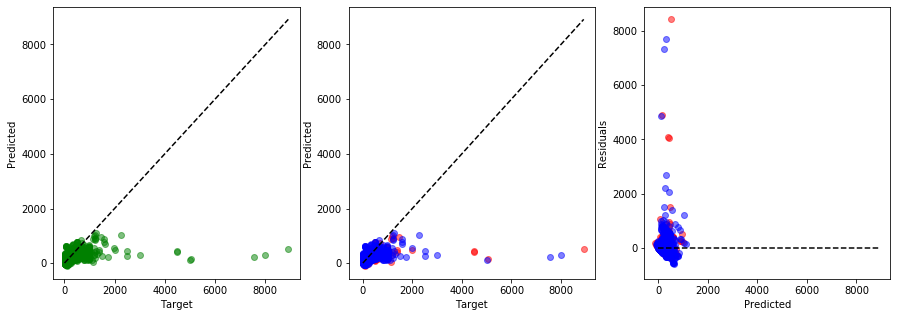

In [ ]:
la_score=show_results(lassocv, 'Lasso Regressor', lassocv.best_params_)

### Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

param_grid_dtr = {"criterion": ["mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

rand_search_est_dtr = RandomizedSearchCV(estimator= DecisionTreeRegressor(), param_distributions = param_grid_dtr, scoring=('neg_mean_absolute_error'), refit="neg_mean_absolute_error",n_iter=12, cv=4, random_state=42, n_jobs=-1, verbose=4)
rand_search_est_dtr.fit(df_train, target_train)

results = pd.DataFrame(rand_search_est_dtr.cv_results_)
display(results)

print("best score is {} with params {}".format((rand_search_est_dtr.best_score_), rand_search_est_dtr.best_params_))

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 12.2min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,65.984032,0.643167,0.008796,0.001118,10,40,5,6,mae,"{'min_samples_split': 10, 'min_samples_leaf': ...",-53.496190,-53.549972,-53.036420,-50.356296,-52.609782,1.316209,3
1,55.373958,0.199989,0.009030,0.001838,10,20,5,2,mae,"{'min_samples_split': 10, 'min_samples_leaf': ...",-54.269828,-54.479955,-53.737719,-50.937041,-53.356200,1.422594,7
2,52.914113,0.226694,0.008166,0.000203,20,40,100,2,mae,"{'min_samples_split': 20, 'min_samples_leaf': ...",-54.269828,-54.479955,-53.737719,-50.937041,-53.356200,1.422594,7
3,65.227527,0.592724,0.008037,0.000539,20,40,5,6,mae,"{'min_samples_split': 20, 'min_samples_leaf': ...",-53.496190,-53.549972,-53.036420,-50.356296,-52.609782,1.316209,3
4,55.144300,0.196619,0.008421,0.000543,10,20,100,2,mae,"{'min_samples_split': 10, 'min_samples_leaf': ...",-54.269828,-54.479955,-53.737719,-50.937041,-53.356200,1.422594,7
5,69.739763,0.457290,0.008359,0.000958,20,20,5,6,mae,"{'min_samples_split': 20, 'min_samples_leaf': ...",-53.496190,-53.549972,-53.036420,-50.356296,-52.609782,1.316209,3
6,54.855444,0.198992,0.008291,0.000268,20,20,20,2,mae,"{'min_samples_split': 20, 'min_samples_leaf': ...",-54.269828,-54.479955,-53.737719,-50.937041,-53.356200,1.422594,7
7,68.989602,2.114691,0.010162,0.001611,20,100,20,8,mae,"{'min_samples_split': 20, 'min_samples_leaf': ...",-49.185718,-49.224308,-49.290796,-46.963015,-48.665996,0.983888,2
8,52.284650,0.176262,0.011170,0.005669,20,40,5,2,mae,"{'min_samples_split': 20, 'min_samples_leaf': ...",-54.269828,-54.479955,-53.737719,-50.937041,-53.356200,1.422594,7
9,52.278969,0.287973,0.010390,0.001133,10,40,20,2,mae,"{'min_samples_split': 10, 'min_samples_leaf': ...",-54.269828,-54.479955,-53.737719,-50.937041,-53.356200,1.422594,7


best score is -47.95130213847131 with params {'min_samples_split': 20, 'min_samples_leaf': 40, 'max_leaf_nodes': 100, 'max_depth': 6, 'criterion': 'mae'}


,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,Decision Tree Regressor:,46.259157,49.556562,47.248444,135.875182,170.636185,147.168843,0.204772,0.152551,0.184563,69.360547,22.112103,31.879944


{'criterion': 'mae',
 'max_depth': 6,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 40,
 'min_samples_split': 20}

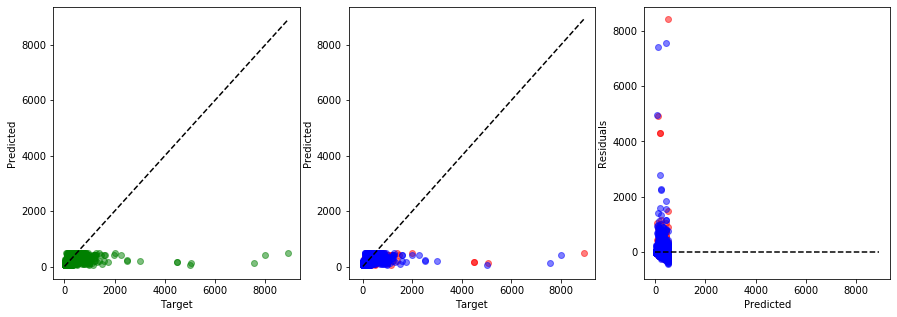

In [ ]:
dtr_score = show_results(rand_search_est_dtr.best_estimator_, 'Decision Tree Regressor', rand_search_est_dtr.best_params_)




###Random Forest Regressor

In [ ]:
parameters_rf = {
    'n_estimators': [int(x) for x in np.linspace(start = 600, stop=1800,num=6)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=8)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap':[True, False],
    'warm_start': [True]
}

# create the grid search instance
rand_search_est_rf = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions = parameters_rf, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'), refit="neg_mean_absolute_error",n_iter=15, cv=4, random_state=42, n_jobs=-1, verbose=5)

# run the grid search
rand_search_est_rf.fit(df_train, target_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(rand_search_est_rf.cv_results_)
display(results)

# print the best parameter setting
print("best score is {} with params {}".format((rand_search_est_rf.best_score_), rand_search_est_rf.best_params_))

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 125.4min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_warm_start,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,1342.211386,12.991685,3.901674,0.467084,True,1560,5,4,auto,38,False,"{'warm_start': True, 'n_estimators': 1560, 'mi...",-31027.485566,-29005.259669,-18118.208506,-13896.796016,-23012.503149,7197.340170,14,-60.742946,-60.988445,-58.341249,-57.945949,-59.504735,1.370946,13
1,100.513605,0.557784,3.785223,0.056588,True,840,2,1,sqrt,81,False,"{'warm_start': True, 'n_estimators': 840, 'min...",-22292.027393,-24660.667837,-12763.900010,-6529.268142,-16561.870289,7305.770106,2,-45.312574,-44.624939,-43.489686,-41.575001,-43.750660,1.414714,3
2,47.257201,0.618441,2.647174,0.060546,True,1080,10,4,sqrt,110,True,"{'warm_start': True, 'n_estimators': 1080, 'mi...",-22737.855813,-25485.707549,-13341.332724,-6369.881873,-16984.100599,7604.397368,6,-46.450204,-45.987857,-44.534129,-42.638378,-44.902751,1.486219,9
3,105.579833,1.810996,3.507743,0.036426,True,1560,10,4,sqrt,52,False,"{'warm_start': True, 'n_estimators': 1560, 'mi...",-22484.644744,-25145.254603,-13001.160088,-6208.309434,-16710.249783,7558.675883,4,-45.465101,-45.055296,-43.639966,-41.870580,-44.007838,1.407482,4
4,912.060405,13.257968,2.577701,0.041814,True,1080,10,4,auto,38,False,"{'warm_start': True, 'n_estimators': 1080, 'mi...",-30849.186533,-28581.880760,-18013.238415,-13708.352643,-22788.733507,7137.823320,13,-60.197564,-59.968605,-57.841308,-57.224128,-58.807999,1.296255,12
5,1320.509668,35.060783,3.415072,0.321854,True,1320,10,1,auto,38,False,"{'warm_start': True, 'n_estimators': 1320, 'mi...",-26362.099638,-26189.343382,-18183.283823,-19430.751605,-22541.639266,3760.806917,11,-58.403629,-61.385190,-59.747197,-58.921472,-59.614287,1.129104,14
6,67.585934,1.647190,2.334085,0.032906,True,1080,10,4,sqrt,110,False,"{'warm_start': True, 'n_estimators': 1080, 'mi...",-22459.718028,-25164.996699,-13047.647623,-6175.015339,-16712.250088,7565.350418,5,-45.553683,-45.051224,-43.750906,-41.827064,-44.045826,1.440000,5
7,44.896179,0.779508,1.573447,0.034760,True,600,2,2,sqrt,24,False,"{'warm_start': True, 'n_estimators': 600, 'min...",-22341.667956,-24812.507929,-12831.248292,-6314.371046,-16575.355801,7422.954456,3,-45.160916,-44.605463,-43.443222,-41.634183,-43.711048,1.349748,2
8,632.087910,21.505594,1.722763,0.058509,True,600,2,2,auto,110,False,"{'warm_start': True, 'n_estimators': 600, 'min...",-32672.654113,-30418.262585,-23143.936409,-17921.527563,-26039.563342,5862.183468,15,-60.393682,-62.518976,-61.057131,-60.417345,-61.096734,0.863152,15
9,502.306163,2.724480,1.826171,0.016649,True,840,10,1,auto,24,True,"{'warm_start': True, 'n_estimators': 840, 'min...",-23335.396296,-24169.667534,-13504.579167,-8892.528814,-17475.956521,6491.988623,9,-45.845965,-45.814985,-44.420281,-43.314628,-44.849035,1.056543,8


best score is -43.63527756781915 with params {'warm_start': True, 'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 81, 'bootstrap': False}


,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,Random Forest Regressor v0:,13.438917,45.277751,22.991196,66.367109,163.83782,105.529655,0.810278,0.218732,0.580717,69.360547,46.369351,66.852632


'-'

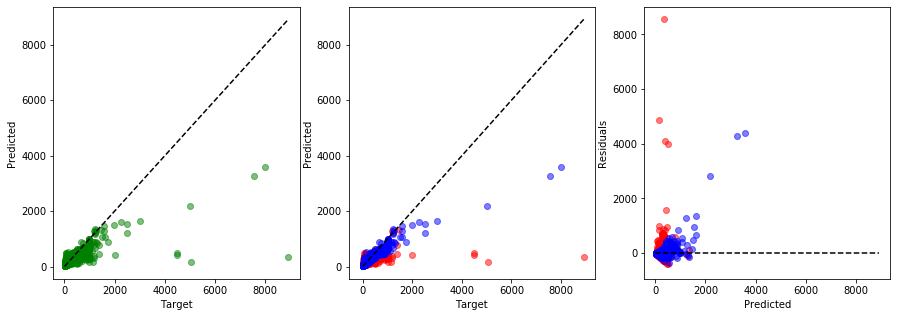

In [ ]:
rfr_v0 = RandomForestRegressor(bootstrap=False,max_depth=81, max_features='sqrt', min_samples_leaf= 2, min_samples_split= 5, n_estimators= 600, warm_start=True, n_jobs=-1)
rfr_v0.fit(df_train, target_train)

rfr_v0_score = show_results(rfr_v0, 'Random Forest Regressor v0', "-")

In [ ]:
#run finer parameter searches with grid search

#change for further details
parameters_rf2 = {
    'warm_start': [True],
    'n_estimators': [600],
    'min_samples_split': [2, 5, 6],
    'min_samples_leaf': [4, 8, 10],
    'max_features': [90, 50],
    'max_depth': [30],
    'bootstrap': [False]
    }

grid_search_rf=GridSearchCV(estimator=RandomForestRegressor(), param_grid = parameters_rf2, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'), refit="neg_mean_absolute_error", cv=5, n_jobs=-1, verbose=4)

grid_search_rf.fit(df_train,target_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_rf.cv_results_)
display(results)

# print the best parameter setting
print("best score is {} with params {}".format((grid_search_rf.best_score_), grid_search_rf.best_params_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 49.5min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_warm_start,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,187.568923,7.974149,1.227259,0.062430,False,30,90,4,2,600,True,"{'bootstrap': False, 'max_depth': 30, 'max_fea...",-7529.337509,-25167.211798,-36947.856218,-5891.234366,-6394.898223,-16386.812768,12556.454193,4,-43.427384,-43.032812,-45.692881,-41.395111,-41.565897,-43.022920,1.553394,5
1,195.772917,7.981378,1.292248,0.079994,False,30,90,4,5,600,True,"{'bootstrap': False, 'max_depth': 30, 'max_fea...",-7398.990024,-25158.601173,-37034.799731,-5969.405641,-6398.873223,-16392.839249,12588.617390,5,-43.254866,-43.007184,-45.754722,-41.422686,-41.491716,-42.986340,1.575784,4
2,189.702101,3.769052,1.332929,0.108042,False,30,90,4,6,600,True,"{'bootstrap': False, 'max_depth': 30, 'max_fea...",-7447.519873,-25170.577226,-37069.572251,-5931.375312,-6414.414515,-16407.397056,12598.616689,6,-43.381625,-43.136635,-45.777424,-41.331816,-41.567418,-43.039087,1.594117,6
3,169.284580,4.799965,0.993732,0.020459,False,30,90,8,2,600,True,"{'bootstrap': False, 'max_depth': 30, 'max_fea...",-7516.517262,-25241.406276,-37224.110697,-5833.710351,-6488.382638,-16461.529266,12654.010122,8,-43.363434,-43.714187,-46.000398,-41.495944,-42.093636,-43.333607,1.560279,11
4,155.653240,1.174551,1.011410,0.081362,False,30,90,8,5,600,True,"{'bootstrap': False, 'max_depth': 30, 'max_fea...",-7508.642955,-25243.545370,-37344.778459,-5842.642667,-6411.701282,-16470.972046,12705.658198,10,-43.460267,-43.733697,-46.057880,-41.473390,-42.051073,-43.355354,1.593802,12
5,164.372134,5.961818,1.056045,0.092550,False,30,90,8,6,600,True,"{'bootstrap': False, 'max_depth': 30, 'max_fea...",-7498.029352,-25181.011570,-37277.634200,-5862.610076,-6403.969320,-16445.359541,12674.345817,7,-43.319229,-43.692784,-46.083904,-41.518189,-41.968362,-43.316589,1.603234,9
6,151.720197,9.351065,0.887875,0.003957,False,30,90,10,2,600,True,"{'bootstrap': False, 'max_depth': 30, 'max_fea...",-7591.400709,-25443.822366,-37438.908267,-5872.613140,-6669.882633,-16604.026492,12706.961180,14,-43.545558,-44.210973,-46.265345,-41.575977,-42.358521,-43.591362,1.619769,17
7,145.041534,2.222238,0.889958,0.010999,False,30,90,10,5,600,True,"{'bootstrap': False, 'max_depth': 30, 'max_fea...",-7601.867120,-25399.187596,-37454.133646,-5925.301695,-6666.493316,-16610.098411,12695.922769,16,-43.468674,-44.197606,-46.230886,-41.749463,-42.289748,-43.587367,1.577128,16
8,143.177352,2.341178,0.876087,0.018361,False,30,90,10,6,600,True,"{'bootstrap': False, 'max_depth': 30, 'max_fea...",-7606.320337,-25429.908548,-37400.904559,-5877.378531,-6674.972772,-16598.597276,12688.845574,13,-43.596948,-44.194750,-46.225542,-41.591125,-42.378473,-43.597454,1.598453,18
9,105.456123,3.108174,1.172027,0.013524,False,30,50,4,2,600,True,"{'bootstrap': False, 'max_depth': 30, 'max_fea...",-7324.326705,-25215.592485,-37012.198813,-5728.561035,-6355.079827,-16327.855568,12646.897636,2,-43.023526,-43.071657,-45.620220,-41.096278,-41.328817,-42.828205,1.621150,3


best score is -42.796807457352095 with params {'bootstrap': False, 'max_depth': 30, 'max_features': 50, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 600, 'warm_start': True}


,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,Random Forest Regressor v1:,7.572057,44.769016,18.731879,60.499913,162.632169,102.456746,0.84234,0.230188,0.604779,69.360547,50.628668,72.993467


'-'

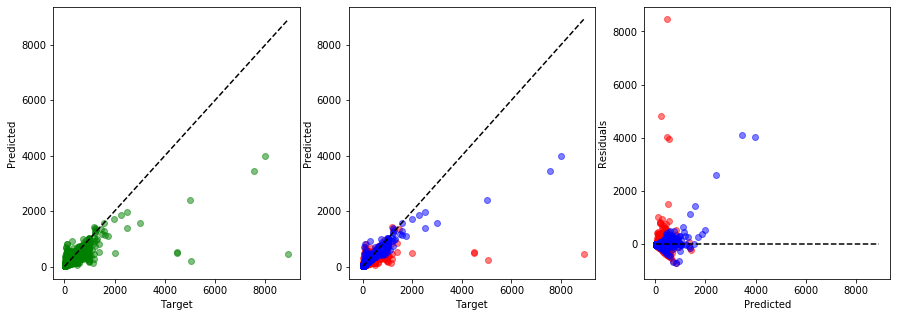

In [ ]:
rfr_v1 = RandomForestRegressor(bootstrap=False,max_depth=30, max_features=90, min_samples_leaf= 2, min_samples_split= 5, n_estimators= 600, warm_start=True, n_jobs=-1)
rfr_v1.fit(df_train, target_train)

rfr_v1_score = show_results(rfr_v1, 'Random Forest Regressor v1', "-")

,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,Random Forest Regressor v2:,21.420778,44.609816,28.377948,94.151584,162.985647,119.058014,0.618173,0.226838,0.466326,69.360547,40.9826,59.086327


'-'

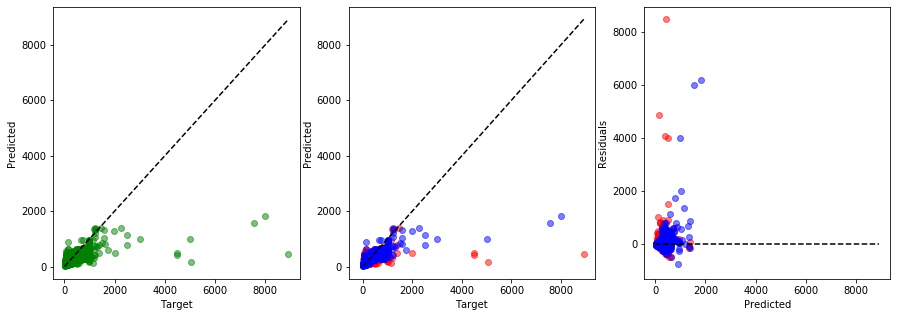

In [ ]:
rfr_v2 = RandomForestRegressor(bootstrap=False,max_depth=30, max_features=50, min_samples_leaf= 5, min_samples_split= 5, n_estimators= 600, warm_start=True, n_jobs=-1)
rfr_v2.fit(df_train, target_train)

rfr_v2_score=show_results(rfr_v2, 'Random Forest Regressor v2', '-')


,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,Random Forest Regressor v3:,28.087259,44.960189,33.149471,104.498075,162.989501,124.955495,0.529643,0.226802,0.412146,69.360547,36.211076,52.207022


'-'

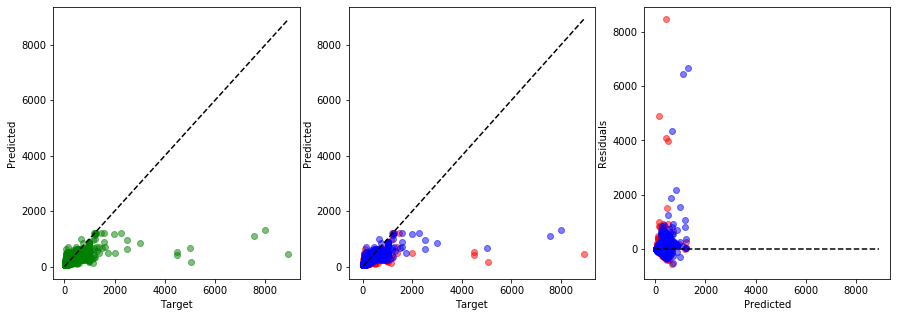

In [ ]:
rfr_v3 = RandomForestRegressor(bootstrap=False,max_depth=30, max_features=50, min_samples_leaf= 8, min_samples_split= 5, n_estimators= 600, warm_start=True, n_jobs=-1)
rfr_v3.fit(df_train, target_train)

rfr_v3_score=show_results(rfr_v3, 'Random Forest Regressor v3', '-')


### XG-Boost


In [ ]:
# split into train and test
xgb_reg_start = time.time()


xgb_param_grid = {
 'n_estimators':[100],
 'learning_rate':[0.01, 0.1],
 'max_depth':[4,6],
 'min_child_weight':[4,6],
 'gamma':[i/10.0 for i in range(0,2)],
 'reg_alpha':[0.1, 1]
}
xgb_reg = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgb_reg, xgb_param_grid, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'), refit="neg_mean_absolute_error", cv=5, n_jobs=-1, verbose=3)
xgb_grid.fit(df_train, target_train)
xgb_reg_end = time.time()
# print the results of all hyper-parameter combinations
results = pd.DataFrame(xgb_grid.cv_results_)
display(results)

# print the best parameter setting
print("best score is {} with params {}".format((xgb_grid.best_score_), xgb_grid.best_params_))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 12.0min finished


[20:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,15.484115,0.350373,0.079831,0.009101,0,0.01,4,4,100,0.1,"{'gamma': 0.0, 'learning_rate': 0.01, 'max_dep...",-13723.595281,-31302.025672,-43686.397368,-11516.115370,-11785.565583,-22403.489179,12952.075614,31,-64.292565,-65.229361,-66.447712,-65.170622,-63.443325,-64.916821,1.006599,31
1,14.924503,0.077294,0.071469,0.001193,0,0.01,4,4,100,1,"{'gamma': 0.0, 'learning_rate': 0.01, 'max_dep...",-13726.229786,-31296.710535,-43684.584534,-11516.222368,-11785.684824,-22402.635665,12950.358903,29,-64.251558,-65.226715,-66.429232,-65.170846,-63.443493,-64.904472,1.005987,29
2,14.981009,0.058304,0.076758,0.007304,0,0.01,4,6,100,0.1,"{'gamma': 0.0, 'learning_rate': 0.01, 'max_dep...",-13498.908002,-31029.296945,-43680.140774,-11603.745946,-11703.551228,-22303.876661,12942.057405,27,-64.078441,-65.235560,-66.214181,-65.271726,-63.289819,-64.818053,1.020918,23
3,14.891244,0.101540,0.072048,0.002570,0,0.01,4,6,100,1,"{'gamma': 0.0, 'learning_rate': 0.01, 'max_dep...",-13495.074199,-31031.708912,-43680.442381,-11601.125292,-11703.706406,-22303.159459,12943.412061,25,-64.039571,-65.238776,-66.214574,-65.261463,-63.289995,-64.808983,1.026063,21
4,21.736521,0.116177,0.087359,0.005092,0,0.01,6,4,100,0.1,"{'gamma': 0.0, 'learning_rate': 0.01, 'max_dep...",-13409.906340,-30781.148698,-43062.275547,-11005.372091,-11351.800146,-21922.846580,12874.567596,23,-64.497604,-65.048447,-66.376899,-64.762024,-63.482028,-64.833496,0.935132,27
5,21.785759,0.223238,0.091818,0.007222,0,0.01,6,4,100,1,"{'gamma': 0.0, 'learning_rate': 0.01, 'max_dep...",-13401.338918,-30792.856510,-43039.623419,-11012.600669,-11344.728357,-21918.975817,12869.812509,21,-64.495313,-65.056721,-66.353792,-64.745791,-63.454494,-64.821319,0.936347,25
6,21.831815,0.286500,0.097967,0.013478,0,0.01,6,6,100,0.1,"{'gamma': 0.0, 'learning_rate': 0.01, 'max_dep...",-13033.554632,-30600.507649,-43177.661024,-10937.344296,-11185.461515,-21787.654037,12976.814006,19,-64.281705,-65.007224,-66.061716,-64.848434,-63.377214,-64.715353,0.882485,19
7,21.876867,0.187787,0.089239,0.008366,0,0.01,6,6,100,1,"{'gamma': 0.0, 'learning_rate': 0.01, 'max_dep...",-13026.043620,-30603.830304,-43182.565680,-10936.122409,-11175.812387,-21785.623632,12981.676747,17,-64.247779,-65.015068,-66.086370,-64.867075,-63.357429,-64.714840,0.900528,17
8,14.670821,0.112449,0.078854,0.011481,0,0.1,4,4,100,0.1,"{'gamma': 0.0, 'learning_rate': 0.1, 'max_dept...",-8628.707073,-25365.879055,-37609.132331,-11127.776498,-6243.035323,-17795.721348,11931.821972,9,-46.152653,-44.462062,-46.803815,-46.055713,-43.213597,-45.337718,1.312003,9
9,14.677722,0.080677,0.080605,0.012431,0,0.1,4,4,100,1,"{'gamma': 0.0, 'learning_rate': 0.1, 'max_dept...",-8628.490185,-25384.557570,-37648.085444,-11078.677743,-6289.942678,-17806.763485,11943.613803,11,-46.152438,-44.701130,-46.803231,-46.278738,-43.471124,-45.481474,1.223308,15


best score is -44.47584152975519 with params {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'reg_alpha': 1}


,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,XG Boost Grid Search:,37.657843,46.336524,40.261619,74.51264,162.731225,108.771975,0.76085,0.22925,0.554557,69.360547,29.098928,41.953141


'-'

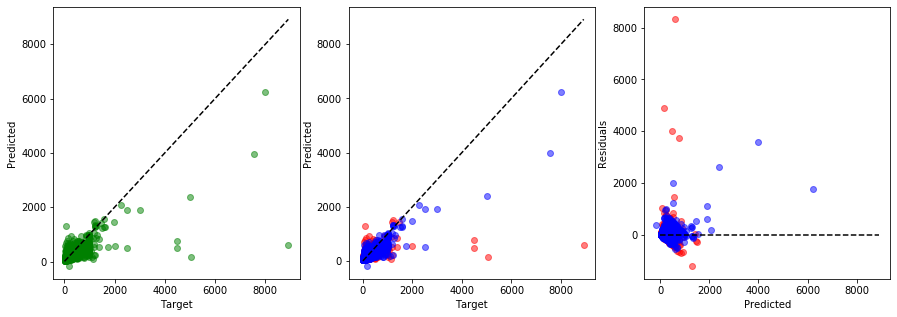

In [ ]:
xgb_grid_scores = show_results(xgb_grid, 'XG Boost Grid Search', "-")

### Multi Layer Perceptron Regression


In [ ]:
nn_param_grid = {
   'mlpregressor__learning_rate':["constant", "invscaling", "adaptive"],
    'mlpregressor__solver':["lbfgs", "sgd", "adam"],
    'mlpregressor__activation':["relu"]
}

nn_pipeline = make_pipeline(
    PolynomialFeatures(1),
    MLPRegressor()
)

nn_grid = GridSearchCV(nn_pipeline, nn_param_grid, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'), refit="neg_mean_absolute_error", cv=3, n_jobs=-1, verbose=3)

# run the grid search
nn_grid.fit(df_train, target_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(nn_grid.cv_results_)
display(results)

# print the best parameter setting
print("best score is {} with params {}".format((nn_grid.best_score_), nn_grid.best_params_))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.9min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpregressor__activation,param_mlpregressor__learning_rate,param_mlpregressor__solver,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,22.628124,0.180871,0.147674,0.002696,relu,constant,lbfgs,"{'mlpregressor__activation': 'relu', 'mlpregre...",-19517.838158,-31587.501022,-6710.970861,-19272.103347,10157.287283,6,-48.125987,-52.159301,-45.236095,-48.507127,2.839207,2
1,3.889532,0.358995,0.135182,0.004946,relu,constant,sgd,"{'mlpregressor__activation': 'relu', 'mlpregre...",-23772.118395,-27445.166193,-8994.683213,-20070.655934,7974.154033,8,-67.475366,-52.504575,-50.836144,-56.938695,7.481622,8
2,36.417827,0.283106,0.121626,0.004692,relu,constant,adam,"{'mlpregressor__activation': 'relu', 'mlpregre...",-19438.681730,-26254.608598,-6653.679008,-17448.989779,8124.787823,1,-49.745023,-50.015225,-49.233075,-49.664441,0.324356,4
3,22.069780,0.487332,0.132470,0.002648,relu,invscaling,lbfgs,"{'mlpregressor__activation': 'relu', 'mlpregre...",-20295.901307,-26061.807462,-6981.246463,-17779.651744,7990.226776,5,-52.350198,-49.163287,-45.983466,-49.165650,2.599208,3
4,30.903712,0.291897,0.125635,0.001835,relu,invscaling,sgd,"{'mlpregressor__activation': 'relu', 'mlpregre...",-21910.876977,-27952.735086,-8047.597083,-19303.736382,8332.727297,7,-57.278717,-55.971199,-53.613509,-55.621142,1.516651,7
5,35.148099,0.217748,0.124708,0.006540,relu,invscaling,adam,"{'mlpregressor__activation': 'relu', 'mlpregre...",-19492.483847,-26572.289554,-6622.716274,-17562.496558,8257.925757,3,-50.220663,-50.953937,-49.646542,-50.273714,0.535059,5
6,21.857135,0.202432,0.131647,0.001804,relu,adaptive,lbfgs,"{'mlpregressor__activation': 'relu', 'mlpregre...",-18903.050850,-26321.491877,-7707.818638,-17644.120455,7650.964521,4,-47.317730,-48.538098,-47.133135,-47.662987,0.623368,1
7,11.831270,0.222803,0.121995,0.003186,relu,adaptive,sgd,"{'mlpregressor__activation': 'relu', 'mlpregre...",-23156.400532,-32657.229762,-11030.380218,-22281.336837,8850.779915,9,-52.726780,-69.617755,-63.899667,-62.081400,7.014548,9
8,29.653434,0.429050,0.077319,0.002908,relu,adaptive,adam,"{'mlpregressor__activation': 'relu', 'mlpregre...",-19531.684196,-26361.907192,-6674.960654,-17522.850681,8161.720614,2,-51.105863,-50.900842,-49.112894,-50.373200,0.895093,6


best score is -47.662987367633654 with params {'mlpregressor__activation': 'relu', 'mlpregressor__learning_rate': 'adaptive', 'mlpregressor__solver': 'lbfgs'}


,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,NN-MLP:,42.939546,51.444658,45.491247,75.356278,171.442911,113.10733,0.755404,0.144519,0.518341,69.360547,23.8693,34.413367


'-'

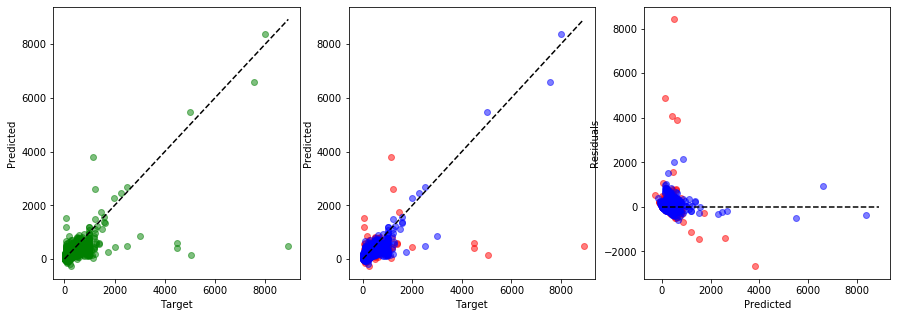

In [ ]:
mlp_scores = show_results(nn_grid.best_estimator_, 'NN-MLP', "-")

###Support Vector Regression

Linear kernel

In [ ]:
param_lin = {'epsilon': [0.1,0.2,0.3,0.4],'C': [5,10,15]}

# RandomizedSearchCV with lin kernel
rand_search_lin = RandomizedSearchCV(estimator=SVR(kernel='linear'), param_distributions = param_lin, cv=3, scoring=('neg_mean_squared_error',"r2"), refit="neg_mean_squared_error",n_iter=10, random_state=42, n_jobs=-1, verbose=3)
rand_search_lin.fit(df_train, target_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(rand_search_lin.cv_results_)
display(results)

# print the best parameter setting
print("best score is {} with params {}".format(sqrt(-rand_search_lin.best_score_), rand_search_lin.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.1min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epsilon,param_C,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,60.017267,1.035515,40.532222,0.726208,0.3,15,"{'epsilon': 0.3, 'C': 15}",-20336.083212,-27568.701095,-6989.424174,-18298.069494,8524.153314,3,0.201182,0.156446,0.392523,0.250050,0.102385,4
1,61.998805,2.358448,39.989586,0.425102,0.2,15,"{'epsilon': 0.2, 'C': 15}",-20336.676939,-27570.474129,-6985.882535,-18297.677868,8526.409588,2,0.201159,0.156392,0.392831,0.250127,0.102548,1
2,49.180721,0.578584,39.864291,0.492383,0.1,5,"{'epsilon': 0.1, 'C': 5}",-20739.843300,-27999.259489,-7274.130954,-18671.077915,8586.523583,9,0.185322,0.143272,0.367778,0.232124,0.097446,8
3,64.223018,1.253097,45.974902,1.049756,0.1,15,"{'epsilon': 0.1, 'C': 15}",-20337.476985,-27571.043020,-6986.256594,-18298.258867,8526.514174,4,0.201127,0.156375,0.392798,0.250100,0.102544,2
4,64.451484,1.283292,48.659453,0.429420,0.2,10,"{'epsilon': 0.2, 'C': 10}",-20480.794789,-27689.736566,-7078.336352,-18416.289236,8540.261201,6,0.195498,0.152743,0.384795,0.244345,0.100835,7
5,57.560152,0.681514,46.180226,2.118090,0.3,5,"{'epsilon': 0.3, 'C': 5}",-20739.540952,-27997.924536,-7275.679988,-18671.048492,8585.330534,8,0.185334,0.143313,0.367643,0.232097,0.097369,10
6,54.355950,3.411478,41.531796,2.266662,0.2,5,"{'epsilon': 0.2, 'C': 5}",-20739.617983,-27999.422407,-7274.922020,-18671.320803,8586.214494,10,0.185331,0.143267,0.367709,0.232102,0.097414,9
7,62.203817,1.061399,39.926864,0.248373,0.4,15,"{'epsilon': 0.4, 'C': 15}",-20335.889022,-27567.366152,-6989.310218,-18297.521797,8523.704289,1,0.201190,0.156487,0.392533,0.250070,0.102376,3
8,55.174215,2.735801,39.781275,0.216994,0.1,10,"{'epsilon': 0.1, 'C': 10}",-20482.894270,-27691.762634,-7076.435594,-18417.030833,8542.004880,7,0.195415,0.152681,0.384960,0.244352,0.100944,6
9,51.536574,3.423434,32.011517,5.565654,0.4,10,"{'epsilon': 0.4, 'C': 10}",-20478.591209,-27690.076112,-7078.538819,-18415.735380,8540.117018,5,0.195584,0.152733,0.384778,0.244365,0.100816,5


best score is 135.26833257369182 with params {'epsilon': 0.4, 'C': 15}


,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,Support Vector Regression Linear:,42.986007,45.962181,43.878918,134.259276,167.417818,145.005871,0.223575,0.184217,0.208356,69.360547,25.481629,36.73793


{'C': 15, 'epsilon': 0.4}

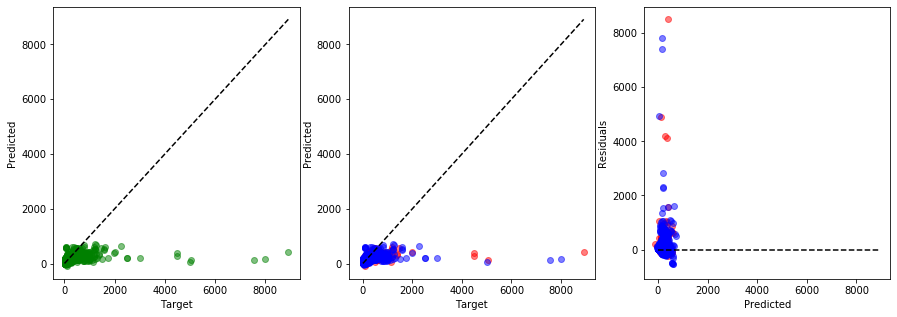

In [ ]:
svr_lin_scores = show_results(rand_search_lin.best_estimator_, 'Support Vector Regression Linear', rand_search_lin.best_params_)

Radial basis function kernel

In [ ]:
param_rbf = {'epsilon': [0.1,0.2,0.3,0.4],'C': [5,10,15]}

# RandomizedSearchCV with rbf kernel
rand_search_rbf = RandomizedSearchCV(estimator=SVR(kernel='rbf'), param_distributions = param_rbf, cv=3, scoring=('neg_mean_squared_error',"r2"), refit="neg_mean_squared_error",n_iter=10, random_state=42, n_jobs=-1, verbose=3)
rand_search_rbf.fit(df_train, target_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(rand_search_rbf.cv_results_)
display(results)

# print the best parameter setting
print("best score is {} with params {}".format(sqrt(-rand_search_rbf.best_score_), rand_search_rbf.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.0min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epsilon,param_C,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,52.091050,0.169192,52.600978,0.077758,0.3,15,"{'epsilon': 0.3, 'C': 15}",-23534.460576,-30750.460040,-9698.723114,-21327.881243,8734.821164,2,0.075547,0.059090,0.157048,0.097228,0.042829,1
1,52.302895,0.148755,53.876560,0.940360,0.2,15,"{'epsilon': 0.2, 'C': 15}",-23534.048716,-30749.495915,-9699.628243,-21327.724291,8734.038121,1,0.075563,0.059120,0.156969,0.097217,0.042781,2
2,52.757234,0.365929,52.963499,2.121959,0.1,5,"{'epsilon': 0.1, 'C': 5}",-24328.940455,-31617.145173,-10488.761241,-22144.948956,8762.781752,9,0.044339,0.032571,0.088382,0.055098,0.024021,9
3,53.181598,0.093385,50.533885,0.281692,0.1,15,"{'epsilon': 0.1, 'C': 15}",-23534.789796,-30750.192647,-9700.269323,-21328.417255,8734.066553,3,0.075534,0.059098,0.156913,0.097182,0.042766,4
4,47.321810,0.168033,49.115508,0.197076,0.2,10,"{'epsilon': 0.2, 'C': 10}",-23821.488538,-31025.922573,-9967.738387,-21605.049833,8738.658582,6,0.064272,0.050662,0.133667,0.082867,0.036348,6
5,47.419419,0.343245,48.662222,0.202257,0.3,5,"{'epsilon': 0.3, 'C': 5}",-24330.346490,-31614.424408,-10488.139963,-22144.303620,8762.193834,8,0.044284,0.032655,0.088436,0.055125,0.024028,8
6,48.077007,0.186254,49.017609,0.199845,0.2,5,"{'epsilon': 0.2, 'C': 5}",-24330.408307,-31615.193569,-10489.673549,-22145.091808,8761.796055,10,0.044282,0.032631,0.088303,0.055072,0.023975,10
7,47.768745,0.311795,48.996563,0.112029,0.4,15,"{'epsilon': 0.4, 'C': 15}",-23534.609711,-30752.327781,-9698.814197,-21328.583897,8735.464917,4,0.075541,0.059033,0.157040,0.097205,0.042843,3
8,48.488908,0.205750,49.728125,0.169933,0.1,10,"{'epsilon': 0.1, 'C': 10}",-23821.212051,-31024.193683,-9965.929976,-21603.778570,8738.816702,5,0.064283,0.050715,0.133824,0.082940,0.036404,5
9,41.465100,4.664041,41.780507,5.425895,0.4,10,"{'epsilon': 0.4, 'C': 10}",-23820.158905,-31031.687169,-9968.175099,-21606.673724,8740.424195,7,0.064325,0.050485,0.133629,0.082813,0.036374,7


best score is 146.04014616290777 with params {'epsilon': 0.2, 'C': 15}


,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,Support Vector Regression RBF:,51.595528,54.044087,52.330144,144.837637,178.821568,155.813741,0.096405,0.069297,0.08595,69.360547,17.030403,24.553444


{'C': 15, 'epsilon': 0.2}

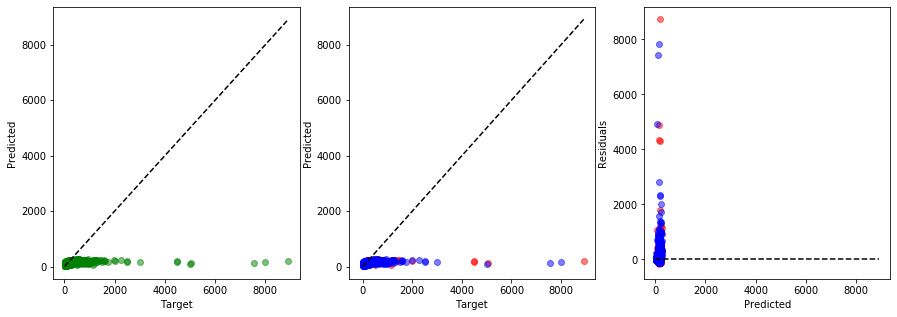

In [ ]:
svr_rbf_scores = show_results(rand_search_rbf.best_estimator_, 'Support Vector Regression RBF', rand_search_rbf.best_params_)

Polynomial kernel

In [ ]:
param_poly = {'epsilon': [0.1,0.2,0.3,0.4],'C': [5,10,15],'degree' : [1,2,3]}

# RandomizedSearchCV with poly kernel
rand_search_poly = RandomizedSearchCV(estimator=SVR(kernel='poly'), param_distributions = param_poly, cv=3, scoring=('neg_mean_squared_error',"r2"), refit="neg_mean_squared_error",n_iter=10, random_state=42, n_jobs=-1, verbose=3)
rand_search_poly.fit(df_train, target_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(rand_search_poly.cv_results_)
display(results)

# print the best parameter setting
print("best score is {} with params {}".format(sqrt(-rand_search_poly.best_score_), rand_search_poly.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.6min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_epsilon,param_degree,param_C,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,43.966475,0.289522,42.175793,0.704302,0.4,3,15,"{'epsilon': 0.4, 'degree': 3, 'C': 15}",-25998.780814,-33330.580131,-12017.174585,-23782.178510,8841.203098,8,-0.021253,-0.019857,-0.044458,-0.028523,0.011282,8
1,43.926502,0.933675,41.973102,1.709663,0.2,1,10,"{'epsilon': 0.2, 'degree': 1, 'C': 10}",-24217.983314,-31495.912950,-10369.130696,-22027.675654,8762.926369,3,0.048698,0.036281,0.098780,0.061253,0.027016,3
2,44.381552,0.224139,40.853096,0.163494,0.3,1,15,"{'epsilon': 0.3, 'degree': 1, 'C': 15}",-23923.525715,-31144.478881,-10066.212751,-21711.405783,8746.177516,1,0.060264,0.047034,0.125108,0.077469,0.034116,1
3,44.901331,0.060939,41.566907,0.379654,0.3,2,15,"{'epsilon': 0.3, 'degree': 2, 'C': 15}",-25221.753891,-32552.318270,-11335.851313,-23036.641158,8798.320135,4,0.009269,0.003957,0.014759,0.009328,0.004410,5
4,45.836440,0.029728,41.581653,0.356532,0.1,2,10,"{'epsilon': 0.1, 'degree': 2, 'C': 10}",-25444.653236,-32790.955839,-11550.714484,-23262.107853,8807.557038,6,0.000513,-0.003345,-0.003916,-0.002249,0.001967,7
5,45.342834,0.235533,41.486811,0.125411,0.4,2,15,"{'epsilon': 0.4, 'degree': 2, 'C': 15}",-25220.826290,-32554.067322,-11335.370446,-23036.754686,8799.087106,5,0.009305,0.003903,0.014800,0.009336,0.004449,4
6,46.763153,2.036133,43.740393,2.015223,0.2,3,10,"{'epsilon': 0.2, 'degree': 3, 'C': 10}",-26083.407257,-33404.783769,-12084.731955,-23857.640994,8845.024173,9,-0.024578,-0.022127,-0.050329,-0.032345,0.012756,9
7,50.341815,0.340246,46.252087,0.219610,0.1,1,10,"{'epsilon': 0.1, 'degree': 1, 'C': 10}",-24216.903238,-31496.926326,-10368.907856,-22027.579140,8763.300220,2,0.048740,0.036250,0.098799,0.061263,0.027028,2
8,49.452505,0.542393,47.623379,0.157169,0.1,3,5,"{'epsilon': 0.1, 'degree': 3, 'C': 5}",-26196.155341,-33498.291544,-12178.017198,-23957.488028,8846.741323,10,-0.029006,-0.024988,-0.058437,-0.037477,0.014911,10
9,43.118025,4.637891,38.234360,6.453908,0.2,2,10,"{'epsilon': 0.2, 'degree': 2, 'C': 10}",-25443.983016,-32792.905631,-11550.198172,-23262.362273,8808.433718,7,0.000539,-0.003405,-0.003871,-0.002245,0.001978,6


best score is 147.34790728947246 with params {'epsilon': 0.3, 'degree': 1, 'C': 15}


,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,Support Vector Regression Polynomial:,53.02989,55.300184,53.711023,146.286992,180.108621,157.200101,0.07823,0.055851,0.069612,69.360547,15.649524,22.562573


{'C': 15, 'degree': 1, 'epsilon': 0.3}

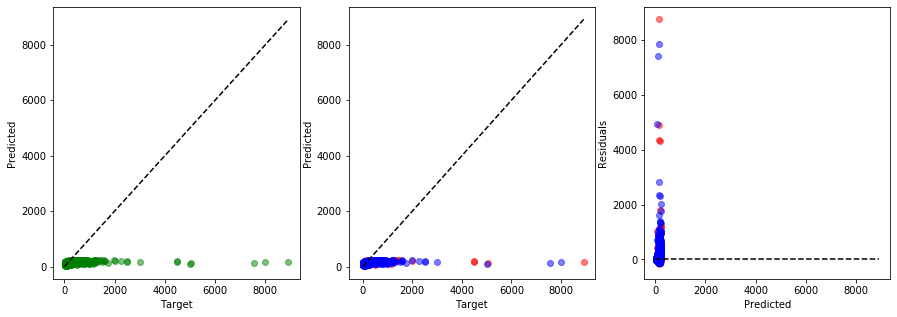

In [ ]:
svr_poly_scores = show_results(rand_search_poly.best_estimator_, 'Support Vector Regression Polynomial', rand_search_poly.best_params_)

##4. Summarizing the results

In [ ]:
# display all scores
all_scores = pd.concat([knn_score, rr_score, la_score, dtr_score, rfr_v0_score, rfr_v1_score, rfr_v2_score, rfr_v3_score, xgb_grid_scores, mlp_scores, svr_lin_scores, svr_rbf_scores, svr_poly_scores], axis = 0)
display(all_scores)

# show weights of features of best identified regression model
eli5.show_weights(rfr_v1, feature_names=list(df.columns))

,algorithm,Train MAE,Test MAE,Total MAE,Train RMSE,Test RMSE,Total RMSE,Train R2,Test R2,Total R2,Baseline,Delta,Improvement in %
0,KNN Regressor:,56.293860,60.741289,57.628177,137.528813,178.583070,151.022357,0.185298,0.071778,0.141301,69.360547,11.732371,16.915049
0,Ridge Regressor:,47.636932,50.559385,48.513726,129.050568,163.385773,140.237321,0.282650,0.223038,0.259567,69.360547,20.846821,30.055734
0,Lasso Regressor:,47.452413,49.535865,48.077489,130.233938,164.303845,141.320697,0.269434,0.214282,0.248083,69.360547,21.283058,30.684674
0,Decision Tree Regressor:,46.259157,49.556562,47.248444,135.875182,170.636185,147.168843,0.204772,0.152551,0.184563,69.360547,22.112103,31.879944
0,Random Forest Regressor v0:,13.438917,45.277751,22.991196,66.367109,163.837820,105.529655,0.810278,0.218732,0.580717,69.360547,46.369351,66.852632
0,Random Forest Regressor v1:,7.572057,44.769016,18.731879,60.499913,162.632169,102.456746,0.842340,0.230188,0.604779,69.360547,50.628668,72.993467
0,Random Forest Regressor v2:,21.420778,44.609816,28.377948,94.151584,162.985647,119.058014,0.618173,0.226838,0.466326,69.360547,40.982600,59.086327
0,Random Forest Regressor v3:,28.087259,44.960189,33.149471,104.498075,162.989501,124.955495,0.529643,0.226802,0.412146,69.360547,36.211076,52.207022
0,XG Boost Grid Search:,37.657843,46.336524,40.261619,74.512640,162.731225,108.771975,0.760850,0.229250,0.554557,69.360547,29.098928,41.953141
0,NN-MLP:,42.939546,51.444658,45.491247,75.356278,171.442911,113.107330,0.755404,0.144519,0.518341,69.360547,23.869300,34.413367


Weight,Feature
0.0955 ± 0.1112,accommodates
0.0568 ± 0.0552,avg2poi
0.0521 ± 0.1065,days_since_last_review
0.0483 ± 0.0919,bedrooms
0.0464 ± 0.0833,beds
0.0374 ± 0.0639,availability_90
0.0333 ± 0.0964,days_since_first_review
0.0312 ± 0.0637,calendar_updated
0.0304 ± 0.0772,extra_people
0.0297 ± 0.0583,availability_60
